# CLASE (IMAGENES REALES)

/home/alumnos/e400777/.conda/envs/dl4i/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


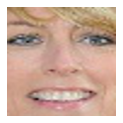

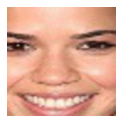

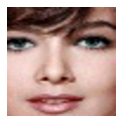

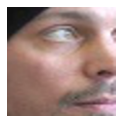

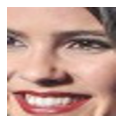

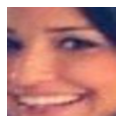

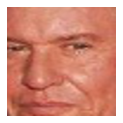

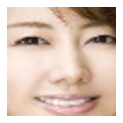

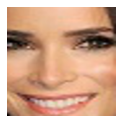

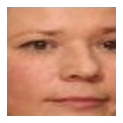

In [1]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from facenet_pytorch import MTCNN
import random


class CustomFaceDataset(Dataset):
    def __init__(self, root_dir, transform=None, resize=128, zoom_factor=-0.15):
        self.root_dir = root_dir
        self.transform = transform
        self.resize = resize
        self.zoom_factor = zoom_factor
        self.mtcnn = MTCNN(keep_all=True, device='cuda' if torch.cuda.is_available() else 'cpu')
        self.images = []
        
        # Cargar los datos
        for img_name in os.listdir(root_dir):
            img_path = os.path.join(root_dir, img_name)
            self.load_image_faces(img_path)

    def load_image_faces(self, img_path):
        img = Image.open(img_path)
        boxes, _ = self.mtcnn.detect(img)
        if boxes is not None:
            for box in boxes:
                # Aquí modificamos el padding para hacer zoom out
                padding_x = (box[2] - box[0]) * self.zoom_factor
                padding_y = (box[3] - box[1]) * self.zoom_factor
                new_box = [
                    max(box[0] - padding_x, 0),  # xmin
                    max(box[1] - padding_y, 0),  # ymin
                    min(box[2] + padding_x, img.width),  # xmax
                    min(box[3] + padding_y, img.height)  # ymax
                ]
                face = img.crop(new_box).resize((self.resize, self.resize))
                self.images.append(face)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        face = self.images[idx]
        if self.transform:
            face = self.transform(face)
        return face


transform = transforms.Compose([
    transforms.ToTensor(),  # Convierte los parches PIL a tensores de PyTorch
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_set = CustomFaceDataset(root_dir='/home/alumnos/e400777/100k', transform=transform)

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)





# Contador para las primeras 10 imágenes
images_count = 0

for images in train_loader:
    for image in images:
        images_count += 1
        image_np = image.numpy().transpose((1, 2, 0))
        plt.figure(figsize=(2, 2))
        plt.imshow(image_np)
        plt.axis('off')
        plt.show()
        
        if images_count == 10:
            break
    if images_count == 10:
        break



# CLASE (IMAGENES REALES) TEST (SOLO PARA VISUALIZACION)

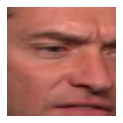

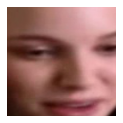

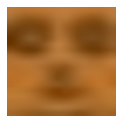

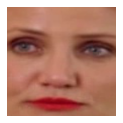

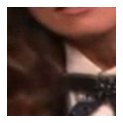

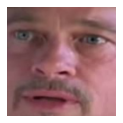

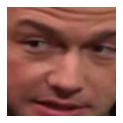

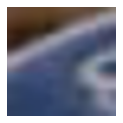

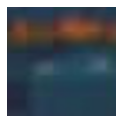

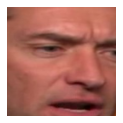

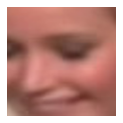

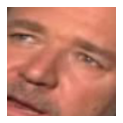

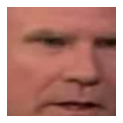

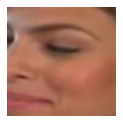

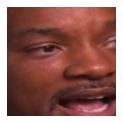

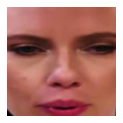

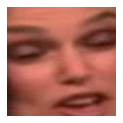

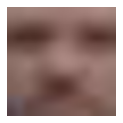

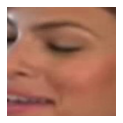

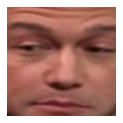

In [2]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class CustomFaceDataset(Dataset):
    def __init__(self, root_dir, transform=None, resize=128, zoom_factor=-0.15):
        self.root_dir = root_dir
        self.transform = transform
        self.resize = resize
        self.zoom_factor = zoom_factor
        self.mtcnn = MTCNN(keep_all=True, device='cuda' if torch.cuda.is_available() else 'cpu')
        self.images = []
        
        # Cargar los datos
        for img_name in os.listdir(root_dir):
            img_path = os.path.join(root_dir, img_name)
            self.load_image_faces(img_path)

    def load_image_faces(self, img_path):
        img = Image.open(img_path)
        boxes, _ = self.mtcnn.detect(img)
        if boxes is not None:
            for box in boxes:
                # Aquí modificamos el padding para hacer zoom out
                padding_x = (box[2] - box[0]) * self.zoom_factor
                padding_y = (box[3] - box[1]) * self.zoom_factor
                new_box = [
                    max(box[0] - padding_x, 0),  # xmin
                    max(box[1] - padding_y, 0),  # ymin
                    min(box[2] + padding_x, img.width),  # xmax
                    min(box[3] + padding_y, img.height)  # ymax
                ]
                face = img.crop(new_box).resize((self.resize, self.resize))
                self.images.append(face)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        face = self.images[idx]
        if self.transform:
            face = self.transform(face)
        return face


test_set_v = CustomFaceDataset(root_dir='/home/alumnos/e400777/Image-Classification-Using-Vision-transformer-main/Task_2_3/evaluation/real', transform=transform)


test_loader_v = DataLoader(test_set_v, batch_size=64, shuffle=True)

# Ahora puedes iterar sobre data_loader para obtener tus lotes de imágenes y etiquetas
import matplotlib.pyplot as plt


import numpy as np

# Contador para las primeras 10 imágenes
images_count = 0

for images in test_loader_v:
    for image in images:
        images_count += 1
        image_np = image.numpy().transpose((1, 2, 0))
        plt.figure(figsize=(2, 2))
        plt.imshow(image_np)
        plt.axis('off')
        plt.show()
        
        # Si ya mostramos 10 imágenes, salimos del bucle
        if images_count == 20:
            break
    # Si ya mostramos 10 imágenes, salimos del bucle externo
    if images_count == 20:
        break



# CLASE TEST (REALES Y FALSAS)

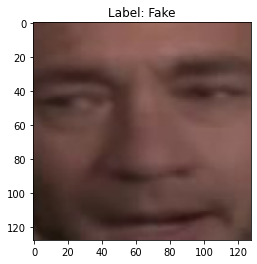

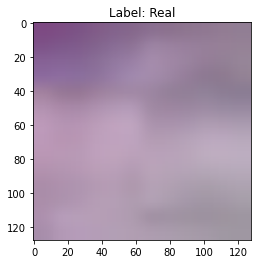

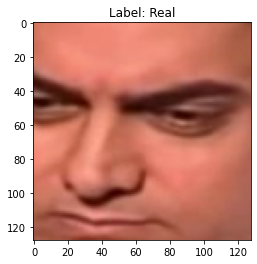

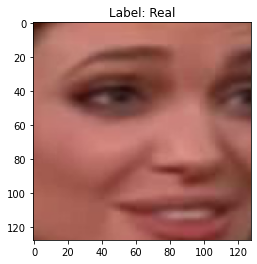

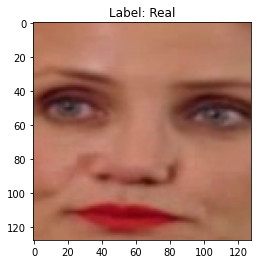

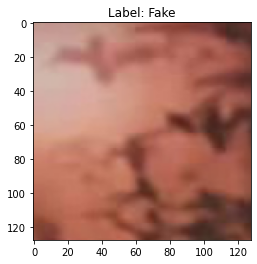

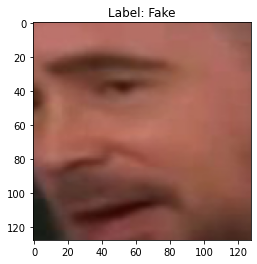

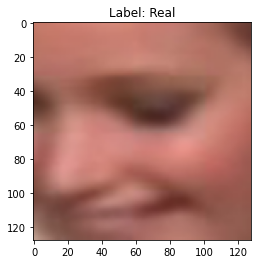

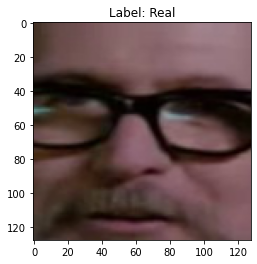

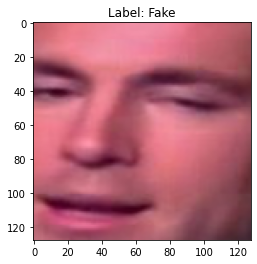

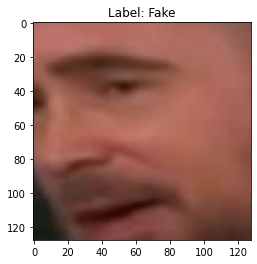

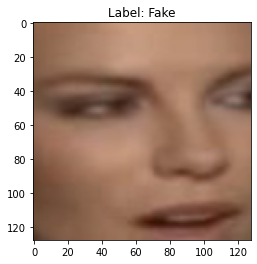

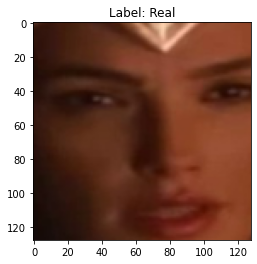

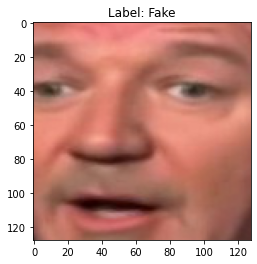

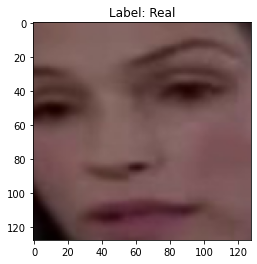

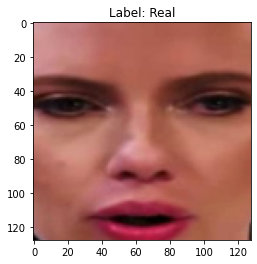

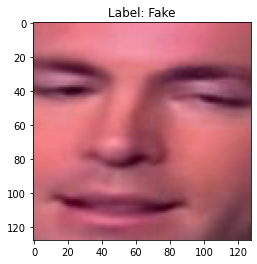

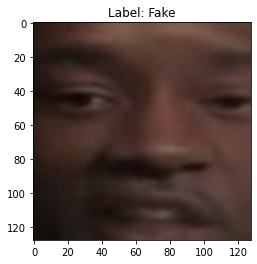

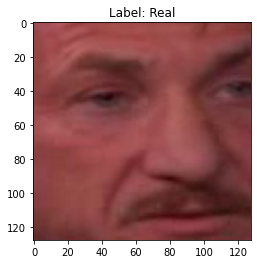

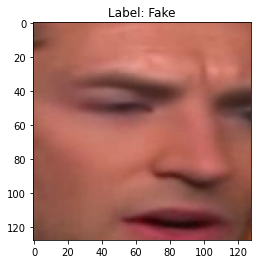

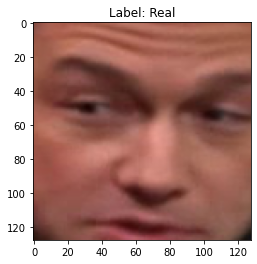

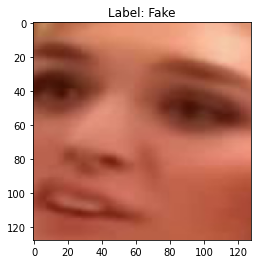

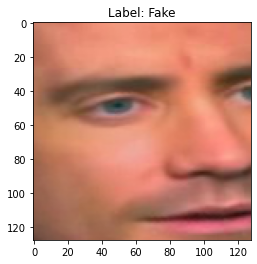

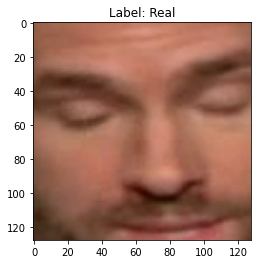

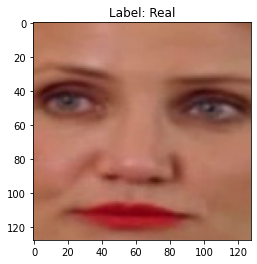

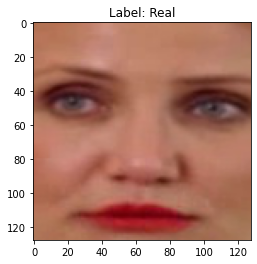

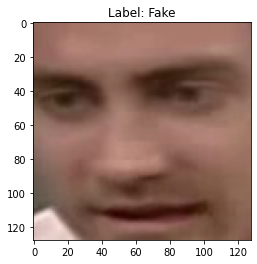

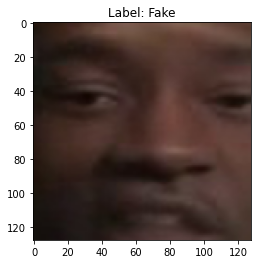

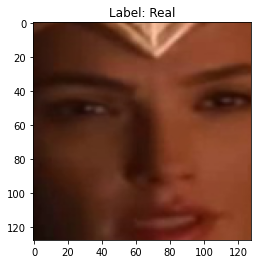

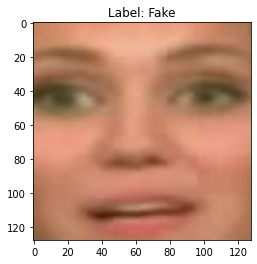

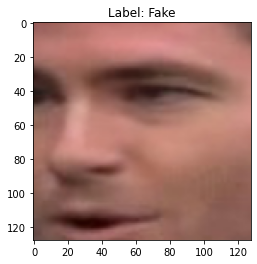

In [3]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from facenet_pytorch import MTCNN
from facenet_pytorch import MTCNN, InceptionResnetV1
import torch
import matplotlib.pyplot as plt
import numpy as np
import random



class DeepfakeFaceDataset(Dataset):
    def __init__(self, root_dir, transform=None, resize=128,zoom_factor=-0.15):
        """
        root_dir (string): Directorio con todas las imágenes, organizadas en subdirectorios 'real' y 'fake'.
        transform (callable, optional): Opcional transformación para ser aplicada en una cara.
        resize (int): Tamaño al cual se redimensionará la cara detectada.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.resize = resize
        self.zoom_factor = zoom_factor
        self.mtcnn = MTCNN(keep_all=True)
        self.data = []
        self.labels = []

        # Cargar los datos
        for label, cls in enumerate(['real', 'fake']):
            cls_folder = os.path.join(root_dir, cls)
            for img_name in os.listdir(cls_folder):
                img_path = os.path.join(cls_folder, img_name)
                self.load_image_faces(img_path, label)

    def load_image_faces(self, img_path, label):
        img = Image.open(img_path)
        boxes, _ = self.mtcnn.detect(img)
        if boxes is not None:
            for box in boxes:  
                padding_x = (box[2] - box[0]) * self.zoom_factor
                padding_y = (box[3] - box[1]) * self.zoom_factor
                new_box = [
                    max(box[0] - padding_x, 0),  # xmin
                    max(box[1] - padding_y, 0),  # ymin
                    min(box[2] + padding_x, img.width),  # xmax
                    min(box[3] + padding_y, img.height)  # ymax
                ]
                face = img.crop(new_box).resize((self.resize, self.resize))
                self.data.append(face)
                self.labels.append(label)


    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        face = self.data[idx]
        label = self.labels[idx]

        if self.transform:
            face = self.transform(face)

        return face, label


transform = transforms.Compose([
    transforms.ToTensor(),  
])
test_set = DeepfakeFaceDataset(root_dir='/home/alumnos/e400777/Image-Classification-Using-Vision-transformer-main/Task_2_3/evaluation', transform=transform)
test_loader = DataLoader(test_set, batch_size=1, shuffle=True)

i = 0
for patches, labels in test_loader:
    if i > 30:
        break
    patch = patches.squeeze(0)  
    plt.imshow(patch.numpy().transpose(1, 2, 0))  
    plt.title(f'Label: {"Real" if labels.item() == 0 else "Fake"}') 
    plt.show()
    i += 1

from torch.utils.data import DataLoader

batch_size = 32

test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)




# AUTOENCODER NORMAL

In [4]:
class ConvAutoencoder(nn.Module):
    def __init__(self, codings_size=100, EPSILON=0.00005, dropout_p=0.1):
        super(ConvAutoencoder, self).__init__()
        
        # Codificador
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm2d(64, eps=EPSILON),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_p),
            nn.Conv2d(64, 128, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm2d(128, eps=EPSILON),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_p),
            nn.Conv2d(128, 256, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm2d(256, eps=EPSILON),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_p),
            nn.Conv2d(256, 512, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm2d(512, eps=EPSILON),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_p),
            nn.Conv2d(512, 1024, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(1024, eps=EPSILON),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_p),
            nn.Flatten(),
            nn.Linear(8*8*1024, codings_size),
            nn.LeakyReLU(0.2)
        )
        
        # Decodificador
        self.decoder = nn.Sequential(
            nn.Linear(codings_size, 8*8*1024),
            nn.LeakyReLU(0.2),
            nn.Unflatten(1, (1024, 8, 8)),
            nn.ConvTranspose2d(1024, 512, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(512, eps=EPSILON),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(512, 256, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.BatchNorm2d(256, eps=EPSILON),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(256, 128, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.BatchNorm2d(128, eps=EPSILON),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.BatchNorm2d(64, eps=EPSILON),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(64, 3, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.BatchNorm2d(3, eps=EPSILON),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    
    
autoencoder = ConvAutoencoder()




device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

autoencoder.to(device)

optimizer = optim.Adam(autoencoder.parameters(), lr=0.005)

criterion = nn.MSELoss()

epochs = 4

for epoch in range(epochs):
    loss_per_epoch = 0
    for data in train_loader:
        images = data  
        images = images.to(device)
        
        optimizer.zero_grad()
        
        outputs = autoencoder(images)
        
        loss = criterion(outputs, images)
        
        loss.backward()
        optimizer.step()
        
        loss_per_epoch += loss.item()
    
    epoch_loss = loss_per_epoch / len(train_loader)
    print(f"Época [{epoch+1}/{epochs}], Pérdida: {epoch_loss:.4f}")



Época [1/4], Pérdida: 0.0117
Época [2/4], Pérdida: 0.0048
Época [3/4], Pérdida: 0.0040
Época [4/4], Pérdida: 0.0035


## VISUALIZAR IN/OUT IMAGENES TRAIN

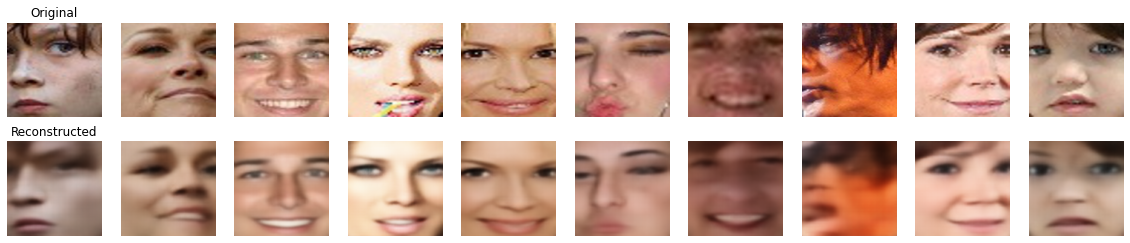

In [5]:
dataiter = iter(train_loader)
images = next(dataiter)  

images = images.to(device)

with torch.no_grad():  
    reconstructed = autoencoder(images)

images = images.cpu()
reconstructed = reconstructed.cpu()

n_images = 10  # Número de imágenes a visualizar

fig, axes = plt.subplots(nrows=2, ncols=n_images, figsize=(20, 4))
for i in range(n_images):
    # Imagen original
    ax = axes[0, i]
    ax.imshow(images[i].permute(1, 2, 0).numpy())
    ax.axis('off')
    if i == 0:
        ax.set_title("Original")

    # Imagen reconstruida
    ax = axes[1, i]
    ax.imshow(reconstructed[i].permute(1, 2, 0).numpy())
    ax.axis('off')
    if i == 0:
        ax.set_title("Reconstructed")

plt.show()


## VISUALIZAR IN/OUT IMAGENES TEST (DA IGUAL REALES O FALSAS)

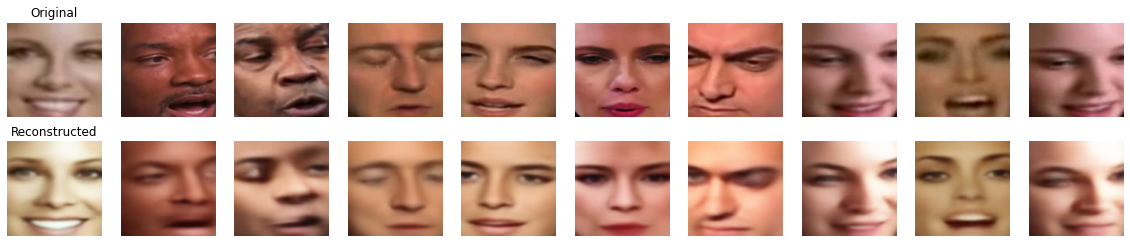

In [9]:
dataiter = iter(test_loader_v)
images = next(dataiter)  

images = images.to(device)

with torch.no_grad():  
    reconstructed = autoencoder(images)

images = images.cpu()
reconstructed = reconstructed.cpu()

n_images = 10  # Número de imágenes a visualizar

fig, axes = plt.subplots(nrows=2, ncols=n_images, figsize=(20, 4))
for i in range(n_images):
    # Imagen original
    ax = axes[0, i]
    ax.imshow(images[i].permute(1, 2, 0).numpy())
    ax.axis('off')
    if i == 0:
        ax.set_title("Original")

    # Imagen reconstruida
    ax = axes[1, i]
    ax.imshow(reconstructed[i].permute(1, 2, 0).numpy())
    ax.axis('off')
    if i == 0:
        ax.set_title("Reconstructed")

plt.show()


# TEST EN AUTOENCODER

In [10]:
import torch

autoencoder.to(device)
autoencoder.eval() 

errores_reales = []
errores_fakes = []

with torch.no_grad():  
    for imagenes, etiquetas in test_loader:
        imagenes = imagenes.to(device)
        etiquetas = etiquetas.to(device)

        reconstrucciones = autoencoder(imagenes)

        # Calcula (MSE) 
        errores = ((imagenes - reconstrucciones)**2).mean(dim=[1, 2, 3]).cpu().numpy()

        # Separa errores x clase
        for error, etiqueta in zip(errores, etiquetas):
            if etiqueta == 0:  #'0' es la etiqueta para imágenes reales
                errores_reales.append(error)
            else:  #cualquier otro valor es para imágenes falsas
                errores_fakes.append(error)

# Calcula la media de los errores para cada clase
media_errores_reales = sum(errores_reales) / len(errores_reales)
media_errores_fakes = sum(errores_fakes) / len(errores_fakes)

print(f"Media de errores para imágenes reales: {media_errores_reales}")
print(f"Media de errores para imágenes falsas: {media_errores_fakes}")


Media de errores para imágenes reales: 0.0017745477610503087
Media de errores para imágenes falsas: 0.0014743469278875958


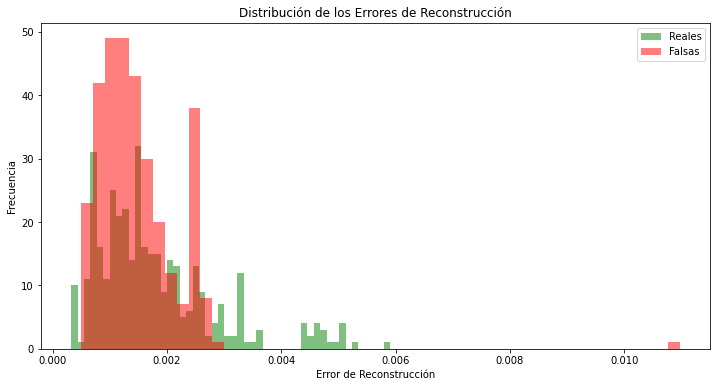

In [11]:
import matplotlib.pyplot as plt
import numpy as np


errores_reales = np.array(errores_reales)
errores_fakes = np.array(errores_fakes)

plt.figure(figsize=(12, 6))

plt.hist(errores_reales, bins=50, alpha=0.5, label='Reales', color='green')

# Histograma para los errores de imágenes falsas
plt.hist(errores_fakes, bins=50, alpha=0.5, label='Falsas', color='red')

plt.xlabel('Error de Reconstrucción')
plt.ylabel('Frecuencia')
plt.title('Distribución de los Errores de Reconstrucción')
plt.legend(loc='upper right')

plt.show()


## INTENTO DE EVALUACION AJUSTANDO UMBRAL

In [12]:
umbral = 0.002

autoencoder.to(device)
autoencoder.eval()

predicciones = []
etiquetas_reales = []

with torch.no_grad():  
    for data in test_loader:
        imagenes, etiquetas = data
        imagenes = imagenes.to(device)
        
        reconstrucciones = autoencoder(imagenes)
        
        error = ((imagenes - reconstrucciones)**2).mean([1, 2, 3])  # Calcula el error por imagen
        
        predicciones_batch = error > umbral
        predicciones.extend(predicciones_batch.cpu().numpy())
        etiquetas_reales.extend(etiquetas.numpy())

from sklearn.metrics import classification_report
print(classification_report(etiquetas_reales, predicciones, target_names=['Real', 'Fake']))


              precision    recall  f1-score   support

        Real       0.49      0.68      0.57       364
        Fake       0.35      0.19      0.25       323

    accuracy                           0.45       687
   macro avg       0.42      0.44      0.41       687
weighted avg       0.42      0.45      0.42       687



# DENOISING AUTOENCODER

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class ConvAutoencoder(nn.Module):
    def __init__(self, codings_size=100, EPSILON=0.00005, dropout_p=0.4):
        super(ConvAutoencoder, self).__init__()
        
        # Codificador
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm2d(64, eps=EPSILON),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_p),
            nn.Conv2d(64, 128, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm2d(128, eps=EPSILON),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_p),
            nn.Conv2d(128, 256, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm2d(256, eps=EPSILON),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_p),
            nn.Conv2d(256, 512, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm2d(512, eps=EPSILON),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_p),
            nn.Conv2d(512, 1024, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(1024, eps=EPSILON),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_p),
            nn.Flatten(),
            nn.Linear(8*8*1024, codings_size),
            nn.LeakyReLU(0.2)
        )
        
        # Decodificador
        self.decoder = nn.Sequential(
            nn.Linear(codings_size, 8*8*1024),
            nn.LeakyReLU(0.2),
            nn.Unflatten(1, (1024, 8, 8)),
            nn.ConvTranspose2d(1024, 512, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(512, eps=EPSILON),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(512, 256, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.BatchNorm2d(256, eps=EPSILON),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(256, 128, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.BatchNorm2d(128, eps=EPSILON),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.BatchNorm2d(64, eps=EPSILON),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(64, 3, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.BatchNorm2d(3, eps=EPSILON),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


    
    
    
    
def add_noise(imgs, noise_factor=0.5):
    """Añade ruido gaussiano a las imágenes."""
    noisy_imgs = imgs + noise_factor * torch.randn_like(imgs)
    noisy_imgs = torch.clamp(noisy_imgs, 0., 1.)  
    return noisy_imgs
def pixelate_images(imgs, pixelation_level=0.5):
    """Pixela un batch de imágenes."""
    batch_size, c, h, w = imgs.size()
    new_h, new_w = int(h * pixelation_level), int(w * pixelation_level)
    imgs = F.interpolate(imgs, size=(new_h, new_w), mode='nearest')
    imgs = F.interpolate(imgs, size=(h, w), mode='nearest')
    return imgs

def add_combined_noise(imgs, gaussian_noise_factor=0.5, pixelation_level=0.3):
    """Añade una combinación de ruido gaussiano y pixelado a las imágenes."""
    noisy_imgs = add_noise(imgs, noise_factor=gaussian_noise_factor)
    noisy_imgs = pixelate_images(noisy_imgs, pixelation_level=pixelation_level)  
    return noisy_imgs


    
    
    
autoencoder = ConvAutoencoder()


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

autoencoder.to(device)

optimizer = optim.Adam(autoencoder.parameters(), lr=0.05)

criterion = nn.MSELoss()

epochs = 4

for epoch in range(epochs):
    loss_per_epoch = 0
    for data in train_loader:
        images = data  
        images = images.to(device)
        
        noisy_images = add_combined_noise(images)
        
        optimizer.zero_grad()
        
        outputs = autoencoder(noisy_images)
        
        loss = criterion(outputs, images)
        
        loss.backward()
        optimizer.step()
        
        loss_per_epoch += loss.item()
    
    epoch_loss = loss_per_epoch / len(train_loader)
    print(f"Época [{epoch+1}/{epochs}], Pérdida: {epoch_loss:.4f}")



Época [1/4], Pérdida: 0.0132
Época [2/4], Pérdida: 0.0080
Época [3/4], Pérdida: 0.0073
Época [4/4], Pérdida: 0.0071


## VISUALIZAR IN/OUT IMAGENES TRAIN

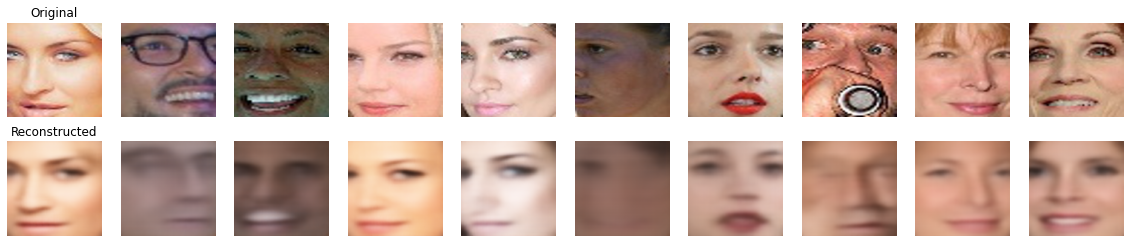

In [15]:
dataiter = iter(train_loader)
images = next(dataiter)  

images = images.to(device)

with torch.no_grad():  
    reconstructed = autoencoder(images)

images = images.cpu()
reconstructed = reconstructed.cpu()

n_images = 10  # Número de imágenes a visualizar

fig, axes = plt.subplots(nrows=2, ncols=n_images, figsize=(20, 4))
for i in range(n_images):
    # Imagen original
    ax = axes[0, i]
    ax.imshow(images[i].permute(1, 2, 0).numpy())
    ax.axis('off')
    if i == 0:
        ax.set_title("Original")

    # Imagen reconstruida
    ax = axes[1, i]
    ax.imshow(reconstructed[i].permute(1, 2, 0).numpy())
    ax.axis('off')
    if i == 0:
        ax.set_title("Reconstructed")

plt.show()


## VISUALIZAR IN/OUT IMAGENES TEST (DA IGUAL REALES O FALSAS)

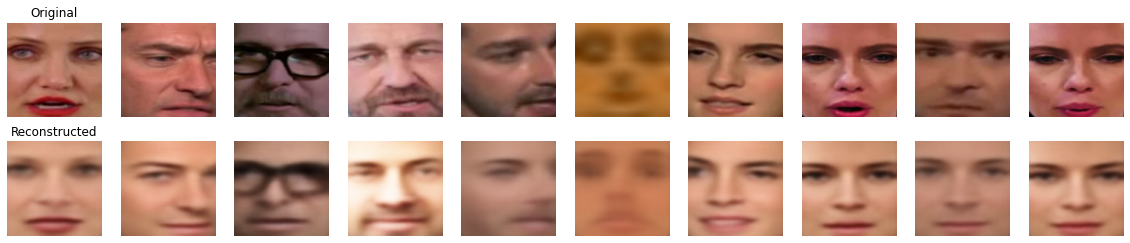

In [16]:
dataiter = iter(test_loader_v)
images = next(dataiter)  

images = images.to(device)

with torch.no_grad():  
    reconstructed = autoencoder(images)

images = images.cpu()
reconstructed = reconstructed.cpu()

n_images = 10  # Número de imágenes a visualizar

fig, axes = plt.subplots(nrows=2, ncols=n_images, figsize=(20, 4))
for i in range(n_images):
    # Imagen original
    ax = axes[0, i]
    ax.imshow(images[i].permute(1, 2, 0).numpy())
    ax.axis('off')
    if i == 0:
        ax.set_title("Original")

    # Imagen reconstruida
    ax = axes[1, i]
    ax.imshow(reconstructed[i].permute(1, 2, 0).numpy())
    ax.axis('off')
    if i == 0:
        ax.set_title("Reconstructed")

plt.show()


# TEST EN DENOISING AUTOENCODER

In [17]:
import torch

autoencoder.to(device)
autoencoder.eval() 

errores_reales = []
errores_fakes = []

with torch.no_grad():  
    for imagenes, etiquetas in test_loader:
        imagenes = imagenes.to(device)
        etiquetas = etiquetas.to(device)

        reconstrucciones = autoencoder(imagenes)

        # Calcula (MSE) 
        errores = ((imagenes - reconstrucciones)**2).mean(dim=[1, 2, 3]).cpu().numpy()

        # Separa errores x clase
        for error, etiqueta in zip(errores, etiquetas):
            if etiqueta == 0:  #'0' es la etiqueta para imágenes reales
                errores_reales.append(error)
            else:  #cualquier otro valor es para imágenes falsas
                errores_fakes.append(error)

# Calcula la media de los errores para cada clase
media_errores_reales = sum(errores_reales) / len(errores_reales)
media_errores_fakes = sum(errores_fakes) / len(errores_fakes)

print(f"Media de errores para imágenes reales: {media_errores_reales}")
print(f"Media de errores para imágenes falsas: {media_errores_fakes}")


Media de errores para imágenes reales: 0.005024503518003398
Media de errores para imágenes falsas: 0.004695548578280806


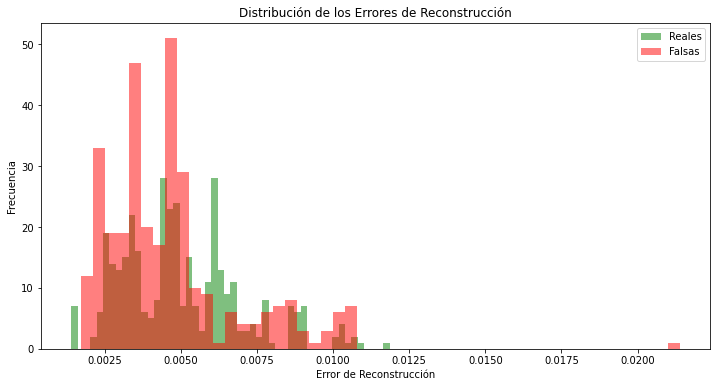

In [20]:
import matplotlib.pyplot as plt
import numpy as np


errores_reales = np.array(errores_reales)
errores_fakes = np.array(errores_fakes)

plt.figure(figsize=(12, 6))

plt.hist(errores_reales, bins=50, alpha=0.5, label='Reales', color='green')

# Histograma para los errores de imágenes falsas
plt.hist(errores_fakes, bins=50, alpha=0.5, label='Falsas', color='red')

plt.xlabel('Error de Reconstrucción')
plt.ylabel('Frecuencia')
plt.title('Distribución de los Errores de Reconstrucción')
plt.legend(loc='upper right')

plt.show()


In [18]:
umbral = 0.002

autoencoder.to(device)
autoencoder.eval()

predicciones = []
etiquetas_reales = []

with torch.no_grad():  
    for data in test_loader:
        imagenes, etiquetas = data
        imagenes = imagenes.to(device)
        
        reconstrucciones = autoencoder(imagenes)
        
        error = ((imagenes - reconstrucciones)**2).mean([1, 2, 3])  # Calcula el error por imagen
        
        predicciones_batch = error > umbral
        predicciones.extend(predicciones_batch.cpu().numpy())
        etiquetas_reales.extend(etiquetas.numpy())

from sklearn.metrics import classification_report
print(classification_report(etiquetas_reales, predicciones, target_names=['Real', 'Fake']))


              precision    recall  f1-score   support

        Real       0.39      0.02      0.04       364
        Fake       0.47      0.97      0.63       323

    accuracy                           0.46       687
   macro avg       0.43      0.49      0.33       687
weighted avg       0.43      0.46      0.32       687



## PROBAR RUIDOS

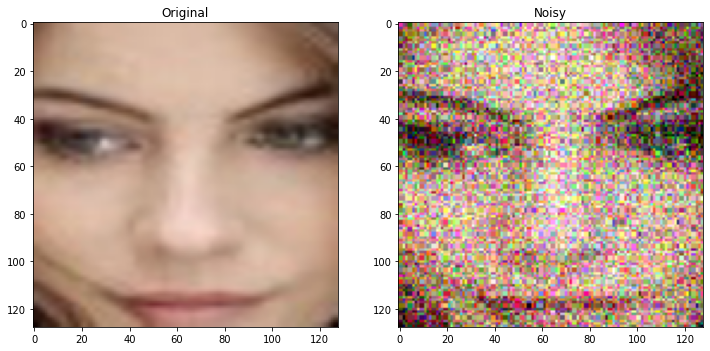

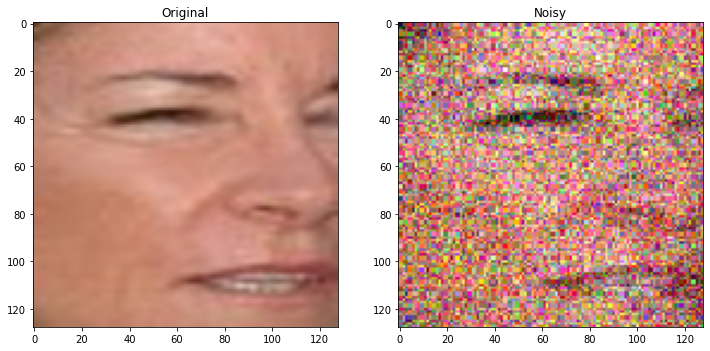

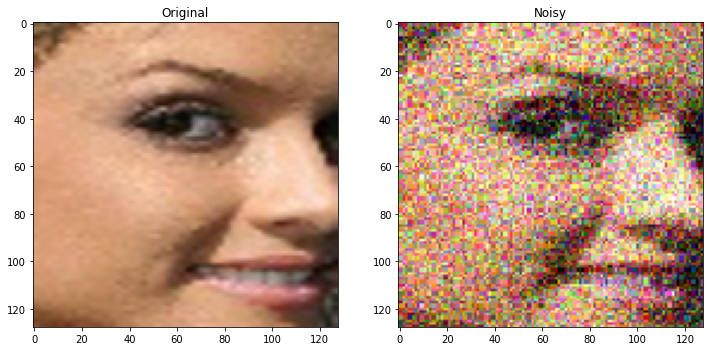

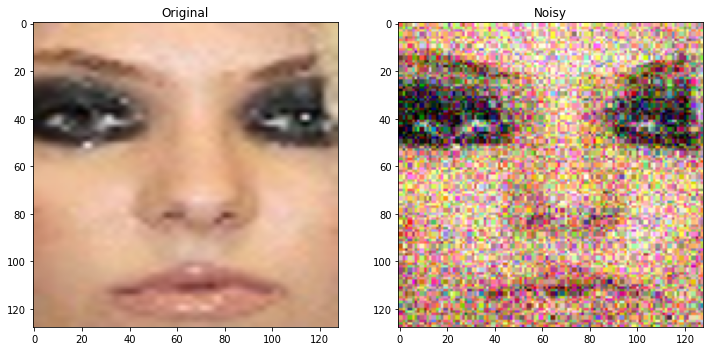

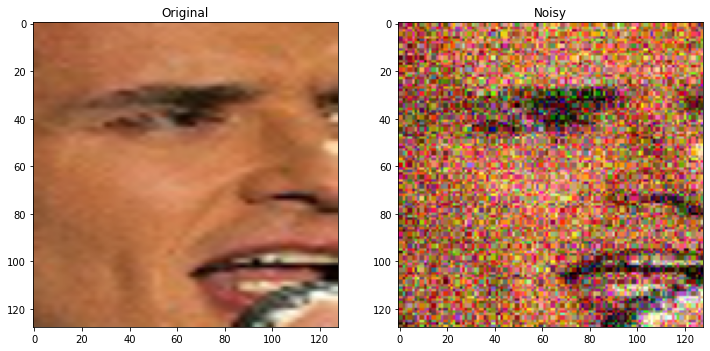

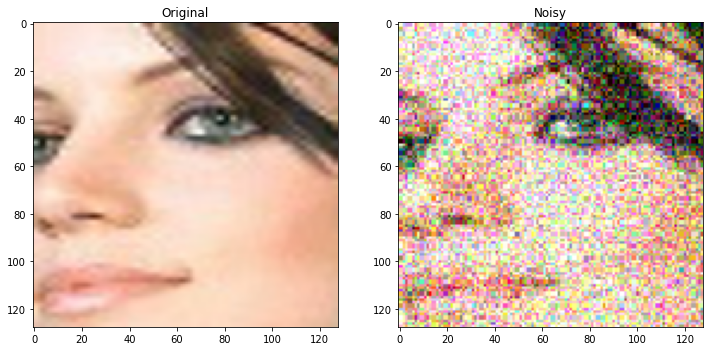

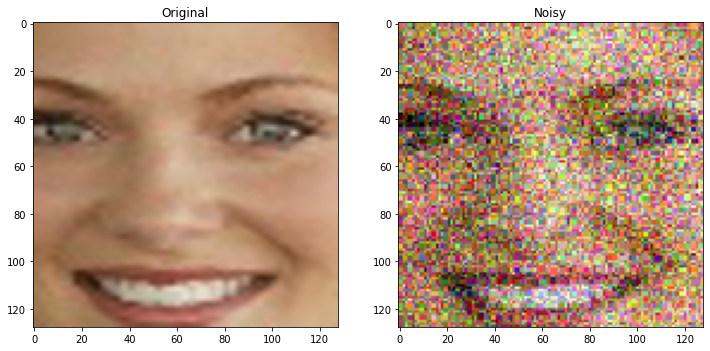

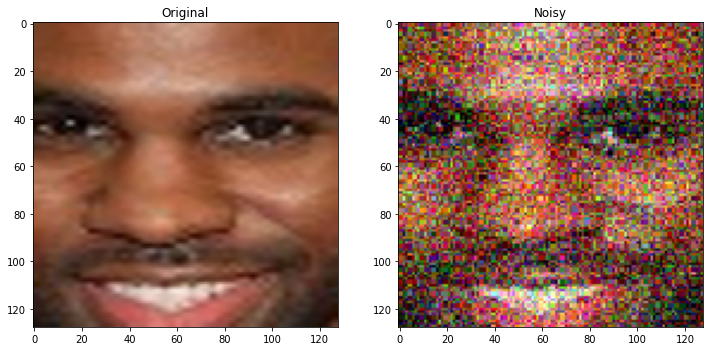

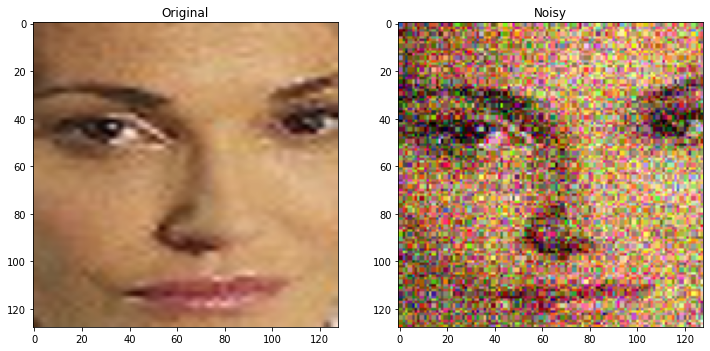

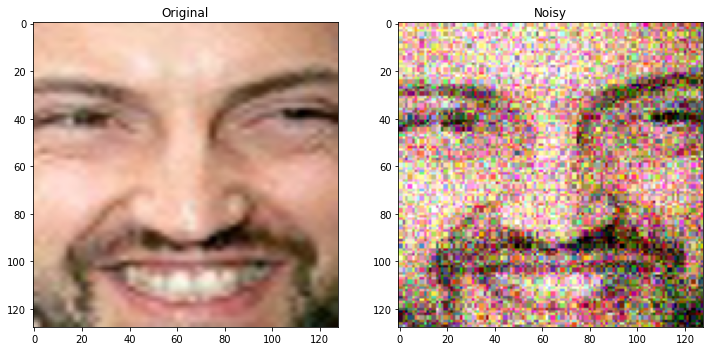

In [29]:
import matplotlib.pyplot as plt
def add_noise(imgs, noise_factor=0.5): 
    """Añade ruido gaussiano a las imágenes."""
    noisy_imgs = imgs + noise_factor * torch.randn_like(imgs)
    noisy_imgs = torch.clamp(noisy_imgs, 0., 1.) 
    return noisy_imgs

def pixelate_image(img, pixelation_level=0.5):
    _, h, w = img.size()
    new_h, new_w = int(h * pixelation_level), int(w * pixelation_level)
    img = F.interpolate(img.unsqueeze(0), size=(new_h, new_w), mode='nearest').squeeze(0)
    img = F.interpolate(img.unsqueeze(0), size=(h, w), mode='nearest').squeeze(0)
    return img
def add_combined_noise(imgs, gaussian_noise_factor=0.2, pixelation_level=0.8):
    """Añade una combinación de ruido gaussiano y pixelado a las imágenes."""
    noisy_imgs = add_noise(imgs, noise_factor=gaussian_noise_factor)
    noisy_imgs = pixelate_image(noisy_imgs, pixelation_level=pixelation_level)
    return noisy_imgs



i = 0
for patches in train_set:
    if i > 9:  
        break

    patch = patches.squeeze(0)  

    # Añade ruido a la imagen
    noisy_patch = add_combined_noise(patch)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(patch.numpy().transpose(1, 2, 0))
    plt.title('Original')
    plt.subplot(1, 2, 2)
    plt.imshow(noisy_patch.numpy().transpose(1, 2, 0))
    plt.title('Noisy')
    plt.show()

    i += 1
